In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt
import scipy.signal as signal
from scipy.interpolate import interp1d
from scipy.signal import medfilt
import pywt
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.spatial import distance
from scipy.fft import fft, fftfreq


In [58]:
person_id = "S2"
data = pd.read_pickle(f'/home/ilya/Downloads/WESAD_old/{person_id}/{person_id}.pkl')

In [59]:
fs_ppg = 64  # Частота дискретизации ФПГ
fs_acc = 32  # Частота дискретизации акселерометра

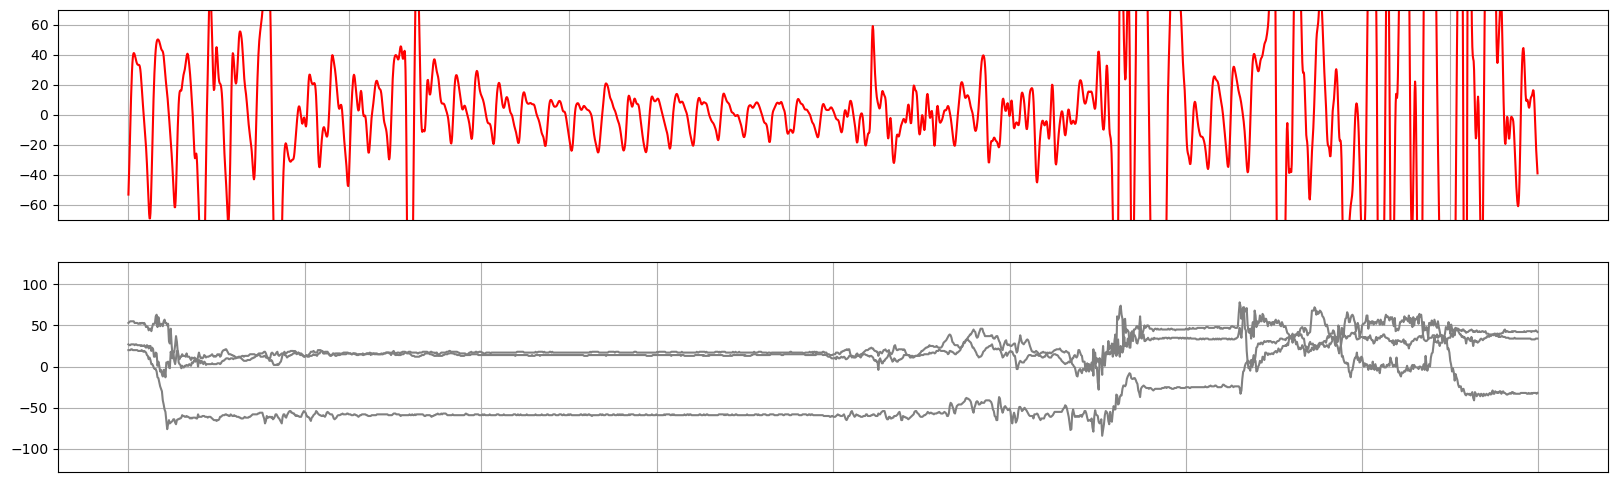

In [60]:
sec_with = 10
count_sec = 50

ppg = data['signal']['wrist']['BVP'][sec_with * fs_ppg : sec_with * fs_ppg + count_sec * fs_ppg].flatten().tolist() # данные с фотоплетизмограммы
ACC_Sx = data['signal']['wrist']['ACC'][sec_with * fs_acc : sec_with * fs_acc + count_sec * fs_acc] # данные акселерометра

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))
ax1.plot(ppg, color='red')
ax1.grid(True)
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax1.set_ylim(-70, 70)

ax2.plot(ACC_Sx, color='grey')
ax2.grid(True)
ax2.set_ylim(-128, 127)
ax2.tick_params(axis='x', which='both', bottom=False, labelbottom=False)

plt.show()


In [61]:
acc_x = ACC_Sx[:, 0]  # Ось X
acc_y = ACC_Sx[:, 1]  # Ось Y
acc_z = ACC_Sx[:, 2]  # Ось Z

In [62]:
def bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)


In [63]:
def adaptive_normalization(signal, window_size=100):
    normalized = np.zeros_like(signal)

    for i in range(len(signal)):
        start = max(0, i - window_size // 2)
        end = min(len(signal), i + window_size // 2)

        local_mean = np.mean(signal[start:end])
        local_std = np.std(signal[start:end])

        normalized[i] = (signal[i] - local_mean) / local_std
    return normalized



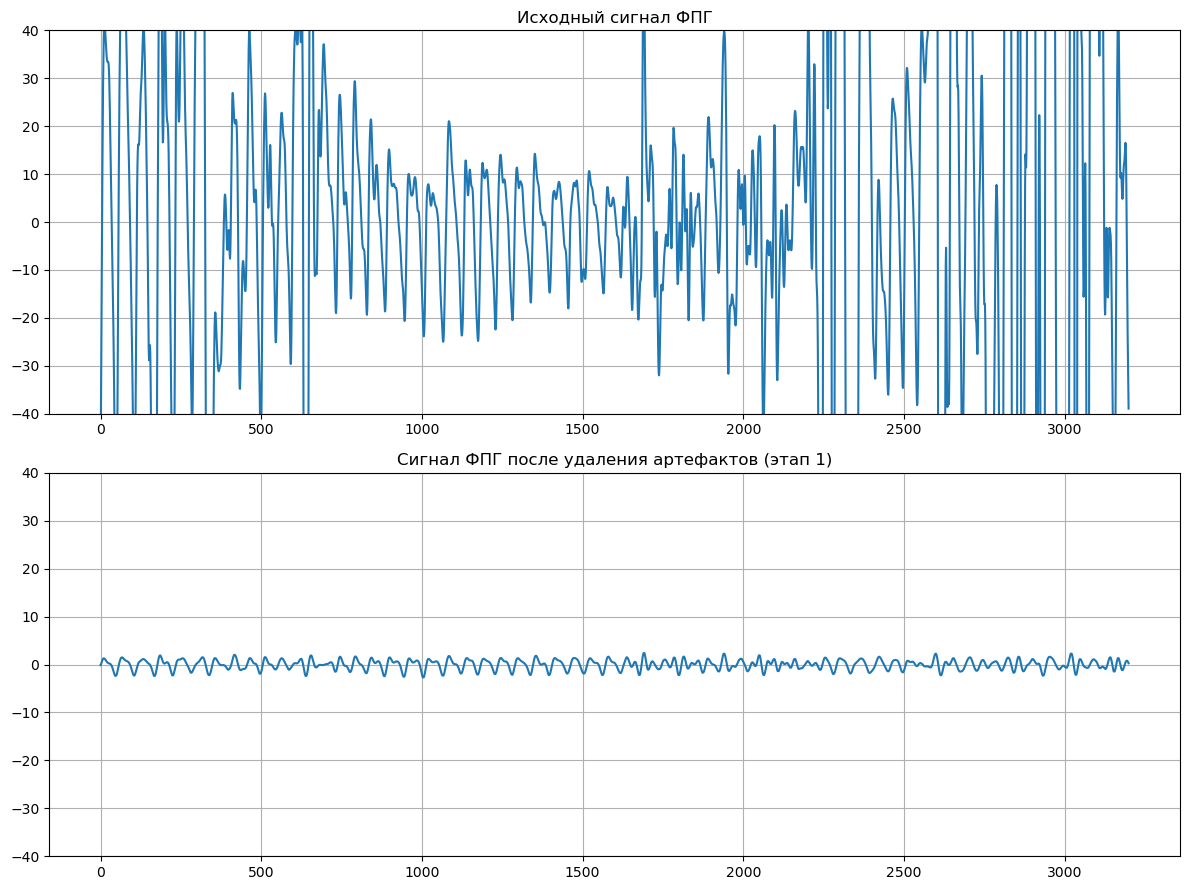

In [64]:
ppg_1_2 = bandpass_filter(ppg, 1, 3, fs_ppg)
ppg_median = medfilt(ppg_1_2, kernel_size=5)
ppg_adaptive = adaptive_normalization(ppg_median)

# coeffs = pywt.wavedec(ppg_adaptive, 'db4', level=3, mode='zero')
# coeffs_thresholded = [pywt.threshold(c, 4, mode='soft') for c in coeffs]
# ppg_wavelet = pywt.waverec(coeffs_thresholded, 'db4')

plt.figure(figsize=(12, 9))  # Увеличиваем высоту для 3 графиков

# Исходный ФПГ
plt.subplot(2, 1, 1)  # 3 строки, 1 столбец, позиция 1
plt.plot(ppg)
plt.title("Исходный сигнал ФПГ")
plt.ylim(-40, 40)
plt.grid(True)

# Очищенный ФПГ (первый этап обработки)
plt.subplot(2, 1, 2)  # 3 строки, 1 столбец, позиция 2
plt.plot(ppg_adaptive)
plt.title("Сигнал ФПГ после удаления артефактов (этап 1)")
plt.ylim(-40, 40)
plt.grid(True)

plt.tight_layout()  # Автоматическая регулировка отступов
plt.show()

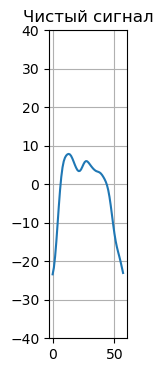

In [65]:
reference_wave_adapt = ppg_adaptive[1007:1065]
reference_wave = ppg[1007:1065]

plt.figure(figsize=(1, 4))
plt.plot(reference_wave)
plt.title("Чистый сигнал")
plt.ylim(-40, 40)
plt.grid(True)

In [66]:
def conv(signal, kernel):
    signal_length = len(signal)
    kernel_length = len(kernel)
    output_length = signal_length - kernel_length + 1
    result = np.zeros(output_length)

    for i in range(output_length):
        signal_slice = signal[i:i + kernel_length]
        norm_signal_slice = signal_slice / np.linalg.norm(signal_slice)
        norm_kernel = kernel / np.linalg.norm(signal_slice)
        
        result[i] = np.dot(norm_signal_slice, norm_kernel)
        
    return result


In [67]:
def chebyshev(signal, kernel):
    signal_length = len(signal)
    kernel_length = len(kernel)
    output_length = signal_length - kernel_length + 1
    result = np.zeros(output_length)

    norm_signal = signal / np.linalg.norm(signal)
    norm_kernel = kernel / np.linalg.norm(signal)

    for i in range(output_length):
        norm_signal_slice = norm_signal[i:i + kernel_length]
        
        # result[i], _ = pearsonr(norm_signal_slice, norm_kernel)
        # result[i] = distance.euclidean(norm_signal_slice, norm_kernel)
        result[i] = distance.chebyshev(norm_signal_slice, norm_kernel)
        
    return result


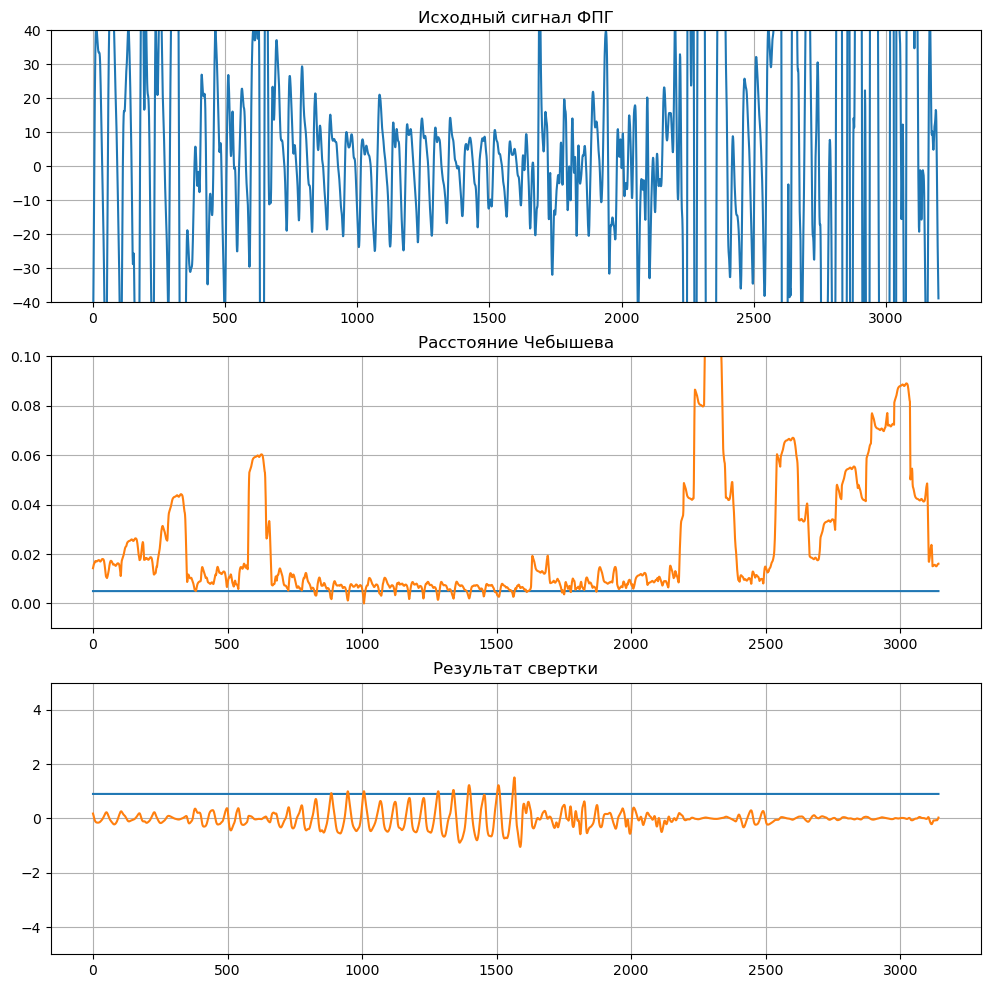

In [68]:
conv_res = conv(ppg, reference_wave)
conv_p = 0.9
chebyshev_res = chebyshev(ppg, reference_wave)
chebyshev_p = 0.005 # порог принятия решения

plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(ppg)
plt.title("Исходный сигнал ФПГ")
plt.ylim(-40, 40)
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot([chebyshev_p] * len(chebyshev_res))
plt.plot(chebyshev_res)
plt.title("Расстояние Чебышева")
plt.ylim(-0.01, 0.1)
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot([conv_p] * len(conv_res))
plt.plot(conv_res)
plt.title("Результат свертки")
plt.ylim(-5, 5)
plt.grid(True)

[False  True False False False False False False False False False False
 False False False False False]


/tmp/ipykernel_18303/2464097434.py:10: RuntimeWarning: divide by zero encountered in log10
  spectrogram = np.log10(np.abs(Zxx))


Text(0.5, 1.0, 'Спектрограмма')

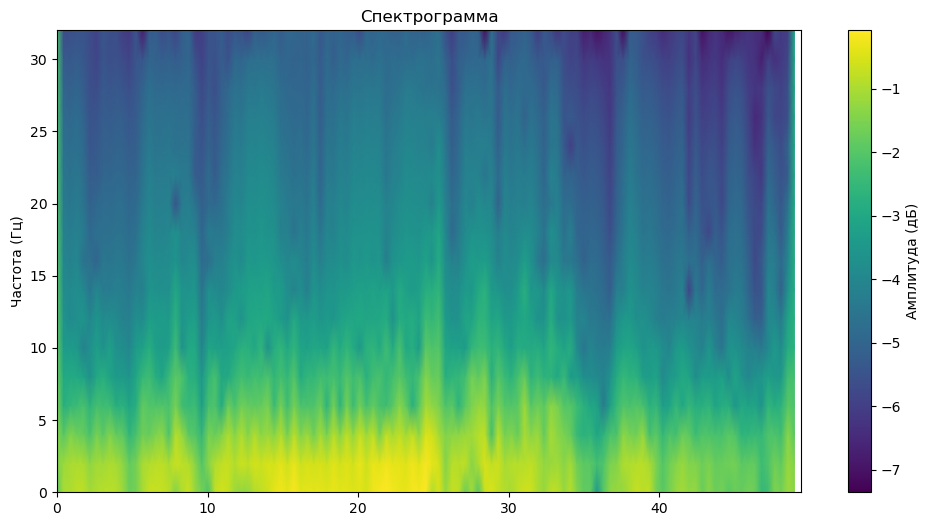

In [83]:
# Вычисление STFT
frequencies, times, Zxx = signal.stft(
    conv_res, 
    fs=64, 
    window='hann', 
    nperseg=32, 
    noverlap=4
)

spectrogram = np.log10(np.abs(Zxx))

# Маска для целевой частоты
freq_mask = (frequencies >= 0.5) & (frequencies <= 2)
print(freq_mask)

# Амплитуда в целевой полосе
amplitude_in_band = np.mean(np.abs(Zxx[freq_mask, :]), axis=0)

# # Создание бинарной маски
# time_mask = amplitude_in_band > min_amplitude

plt.figure(figsize=(12, 6))
plt.pcolormesh(times, frequencies, spectrogram, shading='gouraud', cmap='viridis')
plt.colorbar(label='Амплитуда (дБ)')
plt.ylabel('Частота (Гц)')
plt.title('Спектрограмма')

Text(0, 0.5, 'Амплитуда')

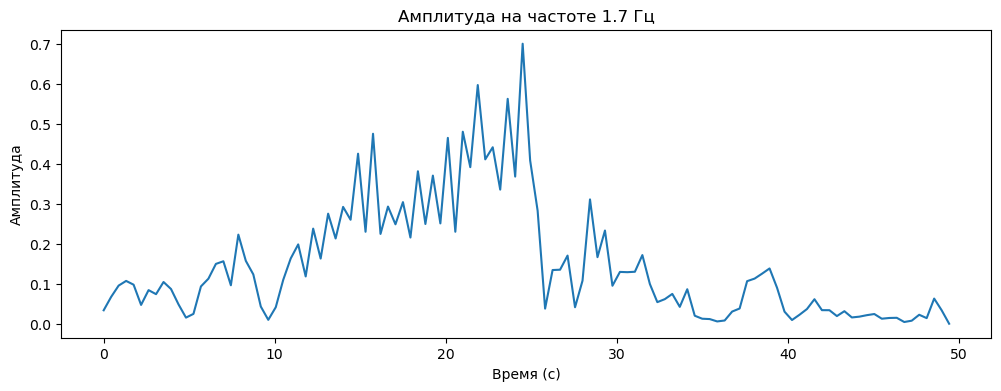

In [84]:
target_freq = 1.7  # Гц
freq_index = np.argmin(np.abs(frequencies - target_freq))
amplitude_at_5Hz = np.abs(Zxx[freq_index, :])

# Построение графика амплитуды
plt.figure(figsize=(12, 4))
plt.plot(times, amplitude_at_5Hz)
plt.title(f'Амплитуда на частоте {target_freq} Гц')
plt.xlabel('Время (с)')
plt.ylabel('Амплитуда')


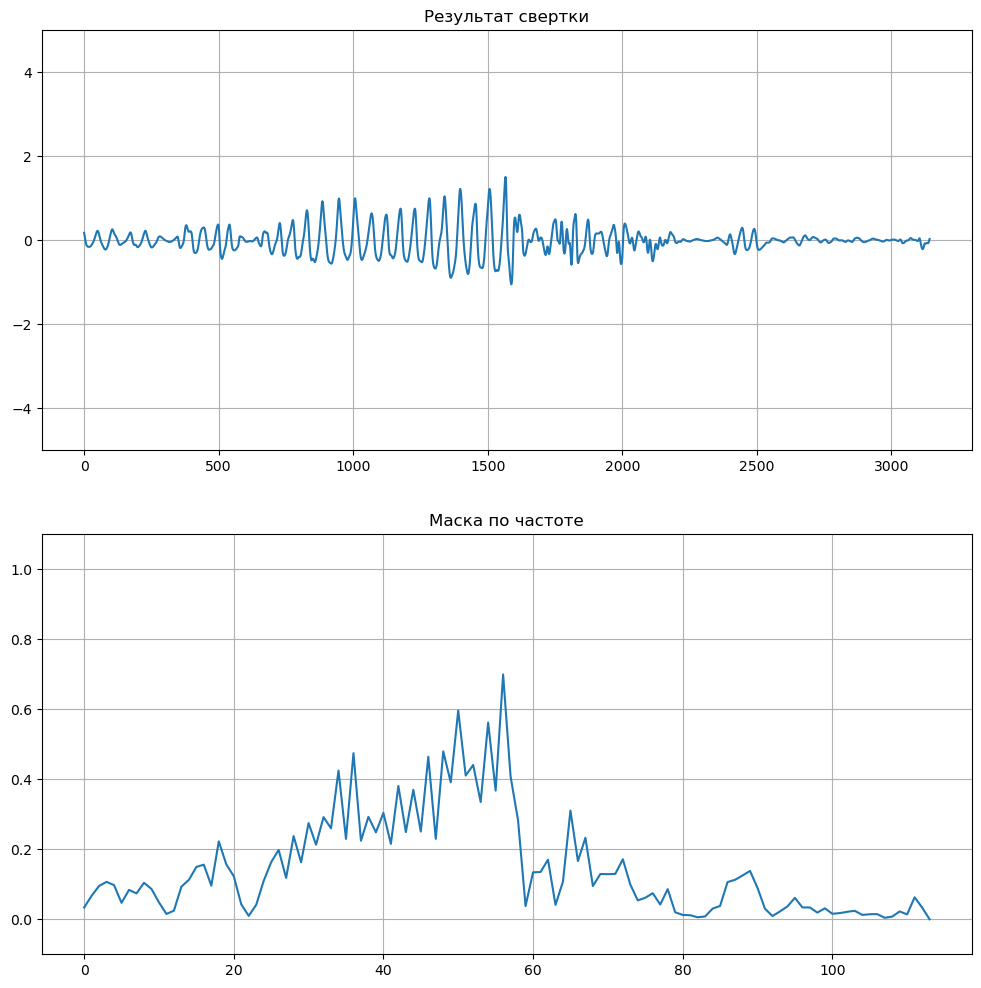

In [85]:
plt.figure(figsize=(12, 12))


plt.subplot(2, 1, 1)
plt.plot(conv_res)
plt.title("Результат свертки")
plt.ylim(-5, 5)
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(amplitude_in_band)
plt.title("Маска по частоте")
plt.ylim(-0.1, 1.1)
plt.grid(True)